## Humor Detection

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K

In [8]:
import random

humor = open('/content/funny_glove.txt','r').read().split('\n')
not_humor = open('/content/notfunny_glove.txt','r').read().split('\n')

random.shuffle(humor)
random.shuffle(not_humor)

# take a sample
humor_ = humor
not_humor_ = not_humor

print("HUMOR:", len(humor_),"NOT HUMOR:", len(not_humor_))

HUMOR: 25000 NOT HUMOR: 25000


In [0]:
import string

# preprocess data and remove various things...

def clean(review):
    return review.replace('\\n',' ')

In [0]:
for i in range(25000):
    humor_[i] = clean(humor_[i])
    not_humor_[i] = clean(not_humor_[i])

## Preprocessing

In [12]:
import numpy as np

texts = []
labels = []

np.random.shuffle(humor_)
np.random.shuffle(not_humor_)


for line in humor_:
    texts.append(line)
    labels.append(1)

for line in not_humor_:
    texts.append(line)
    labels.append(0)

print('Funny', len(humor_))    
print("Not Funny",len(not_humor_))  
print("Total", len(texts))

Funny 25000
Not Funny 25000
Total 50000


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenizing words

# max word length
maxlen = 500
# take top 20k words only
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 79130 unique tokens
Shape of data tensor: (50000, 500)
Shape of labels tensor: (50000,)


## Loading the pre-trained word embeddings

In [16]:
# we would use stanford's GloVe pre-trained word embeddings
# download the GloVe word embeddings
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2019-04-25 01:03:18--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  2.59MB/s    in 7m 46s  

2019-04-25 01:11:04 (1.76 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [19]:
!unzip /content/glove.6B.zip.1

Archive:  /content/glove.6B.zip.1
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Archive:  /content/glove.42B.300d.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/glove.42B.300d.zip or
        /content/glove.42B.300d.zip.zip, and cannot find /content/glove.42B.300d.zip.ZIP, period.


In [21]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
f.close()

print(len(embeddings_index))

400000


In [0]:
# preparing glove word embeddings matrix
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer --- using GloVe pre-trained word embeddings

In [69]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import RMSprop


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 300)          6000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 150000)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                9600064   
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 15,600,129
Trainable params: 15,600,129
Non-trainable params: 0
_________________________________________________________________


### Load the pre-trained word embeddings into the embedding layer and freeze it

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [71]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-6), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=25, batch_size=32, validation_split=0.50)

Train on 25000 samples, validate on 25000 samples
Epoch 1/25
25000/25000 [==============================] - 9s 358us/step - loss: 0.6216 - acc: 0.6747 - val_loss: 0.6036 - val_acc: 0.7010
Epoch 2/25
25000/25000 [==============================] - 8s 302us/step - loss: 0.5870 - acc: 0.7102 - val_loss: 0.5902 - val_acc: 0.7038
Epoch 3/25
25000/25000 [==============================] - 7s 294us/step - loss: 0.5721 - acc: 0.7165 - val_loss: 0.5855 - val_acc: 0.7060
Epoch 4/25
25000/25000 [==============================] - 7s 293us/step - loss: 0.5621 - acc: 0.7189 - val_loss: 0.5808 - val_acc: 0.7072
Epoch 5/25
25000/25000 [==============================] - 7s 293us/step - loss: 0.5541 - acc: 0.7238 - val_loss: 0.5777 - val_acc: 0.7094
Epoch 6/25
25000/25000 [==============================] - 7s 294us/step - loss: 0.5450 - acc: 0.7278 - val_loss: 0.5745 - val_acc: 0.7106
Epoch 7/25
25000/25000 [==============================] - 7s 294us/step - loss: 0.5387 - acc: 0.7297 - val_loss: 0.5729 - 

(50,)

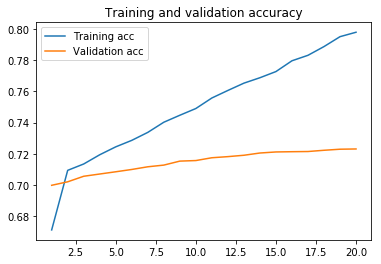

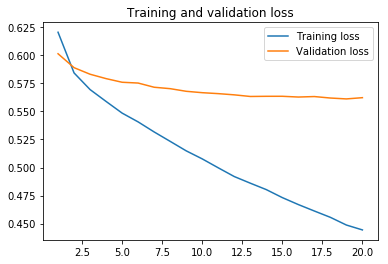

In [68]:
# plotting the results

import matplotlib.pyplot as plt
%matplotlib inline

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_result(history)